In [1]:
import numpy as np
import keras
from keras import backend as K
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, Bidirectional, LSTM, Dense, TimeDistributed, Dropout
from keras_contrib.layers.crf import CRF
import matplotlib.pyplot as plt
import os
from keras.models import Model
from keras.callbacks import ReduceLROnPlateau
import json
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

Using TensorFlow backend.


In [2]:
sample_x = []
sample_y = []
vocabs = {'UNK'}
datas = []
for line in open('/home/wcb/nerXY/train_data/3.2_train.txt', 'r', encoding='utf-8'):
    line = line.rstrip().split('\t')
    if not line:
        continue
    char = line[0]
    if not char:
        continue
    cate = line[-1]
    sample_x.append(char)
    sample_y.append(cate)
    vocabs.add(char)
    if char in ['.', '?', '!']:
        datas.append([sample_x, sample_y])
        sample_x = []
        sample_y = []
word_dict = {wd:index for index,wd in enumerate(list(vocabs))}

In [3]:
file = open('/home/wcb/nerXY/word_dict/3.2_word_dict.txt', 'w') 
for k,v in word_dict.items():
    file.write(str(v) + ' ' + str(k) + '\n')
file.close()

In [4]:
class_dict = {'O':0,
              'I-OTHE':1,
              'I-ISOE':2,
             }
x_train = [[word_dict[char] for char in data[0]] for data in datas]
y_train = [[class_dict[label] for label in data[1]] for data in datas]
x_train = pad_sequences(x_train, maxlen=40, padding='post')
y = pad_sequences(y_train, maxlen=40, padding='post')
y_train = np.expand_dims(y, axis=2)

In [5]:
embeddings_dict = {}
with open('/home/wcb/nerXY/w2v/3.2_w2v.txt', 'r', encoding='utf-8') as f:
    for line in f:
        values = line.strip().split(' ')
        if len(values) < 64:
            continue
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_dict[word] = coefs
print('Found %s word vectors.' % len(embeddings_dict))

embedding_matrix = np.zeros((len(word_dict) + 1, 64))
for word, i in word_dict.items():
    embedding_vector = embeddings_dict.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

Found 1809 word vectors.


In [6]:
model = Sequential()
embedding_layer = Embedding(len(word_dict) + 1,
                            64,
                            weights=[embedding_matrix],
                            input_length=40,
                            trainable=False,
                            mask_zero=True)
model.add(embedding_layer)
model.add(Bidirectional(LSTM(8, return_sequences=True,  activation='softsign')))
model.add(Dropout(0.5))
model.add(TimeDistributed(Dense(len(class_dict))))
crf_layer = CRF(len(class_dict), sparse_target=True)
model.add(crf_layer)
model.compile(optimizer='AdaGrad', loss=crf_layer.loss_function, metrics=[crf_layer.accuracy])
model.summary()










Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.



/Users/yvse/opt/anaconda3/envs/keras/lib/python3.7/site-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/Users/yvse/opt/anaconda3/envs/keras/lib/python3.7/site-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 40, 64)            115840    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 40, 16)            4672      
_________________________________________________________________
dropout_1 (Dropout)          (None, 40, 16)            0         
_________________________________________________________________
time_distributed_1 (TimeDist (None, 40, 3)             51        
_________________________________________________________________
crf_1 (CRF)                  (None, 40, 3)             27        
Total params: 120,590
Trainable params: 4,750
Non-trainable params: 115,840
_________________________________________________________________


In [7]:
history = model.fit(x_train[:], y_train[:], validation_split=0.10, batch_size=64, epochs=1000)



Train on 1664 samples, validate on 185 samples
Epoch 1/1000
1664/1664 [==============================] - 2s 1ms/step - loss: 1.7102 - crf_viterbi_accuracy: 0.8475 - val_loss: 1.6579 - val_crf_viterbi_accuracy: 0.9269
Epoch 2/1000
1664/1664 [==============================] - 1s 532us/step - loss: 1.5604 - crf_viterbi_accuracy: 0.9152 - val_loss: 1.6413 - val_crf_viterbi_accuracy: 0.9269
Epoch 3/1000
1664/1664 [==============================] - 1s 532us/step - loss: 1.5429 - crf_viterbi_accuracy: 0.9149 - val_loss: 1.6399 - val_crf_viterbi_accuracy: 0.9269
Epoch 4/1000
1664/1664 [==============================] - 1s 537us/step - loss: 1.5277 - crf_viterbi_accuracy: 0.9153 - val_loss: 1.6381 - val_crf_viterbi_accuracy: 0.9269
Epoch 5/1000
1664/1664 [==============================] - 1s 544us/step - loss: 1.5176 - crf_viterbi_accuracy: 0.9162 - val_loss: 1.6364 - val_crf_viterbi_accuracy: 0.9269
Epoch 6/1000
1664/1664 [==============================] - 1s 535us/step - loss: 1.5094 - crf_

Epoch 46/1000
1664/1664 [==============================] - 1s 553us/step - loss: 1.3436 - crf_viterbi_accuracy: 0.9452 - val_loss: 1.5142 - val_crf_viterbi_accuracy: 0.9286
Epoch 47/1000
1664/1664 [==============================] - 1s 555us/step - loss: 1.3417 - crf_viterbi_accuracy: 0.9457 - val_loss: 1.5116 - val_crf_viterbi_accuracy: 0.9286
Epoch 48/1000
1664/1664 [==============================] - 1s 611us/step - loss: 1.3389 - crf_viterbi_accuracy: 0.9466 - val_loss: 1.5088 - val_crf_viterbi_accuracy: 0.9286
Epoch 49/1000
1664/1664 [==============================] - 1s 600us/step - loss: 1.3376 - crf_viterbi_accuracy: 0.9471 - val_loss: 1.5059 - val_crf_viterbi_accuracy: 0.9293
Epoch 50/1000
1664/1664 [==============================] - 1s 575us/step - loss: 1.3355 - crf_viterbi_accuracy: 0.9468 - val_loss: 1.5035 - val_crf_viterbi_accuracy: 0.9291
Epoch 51/1000
1664/1664 [==============================] - 1s 554us/step - loss: 1.3324 - crf_viterbi_accuracy: 0.9481 - val_loss: 1.50

1664/1664 [==============================] - 1s 590us/step - loss: 1.2566 - crf_viterbi_accuracy: 0.9729 - val_loss: 1.3891 - val_crf_viterbi_accuracy: 0.9784
Epoch 141/1000
1664/1664 [==============================] - 1s 590us/step - loss: 1.2560 - crf_viterbi_accuracy: 0.9728 - val_loss: 1.3886 - val_crf_viterbi_accuracy: 0.9793
Epoch 142/1000
1664/1664 [==============================] - 1s 577us/step - loss: 1.2552 - crf_viterbi_accuracy: 0.9739 - val_loss: 1.3877 - val_crf_viterbi_accuracy: 0.9795
Epoch 143/1000
1664/1664 [==============================] - 1s 577us/step - loss: 1.2532 - crf_viterbi_accuracy: 0.9740 - val_loss: 1.3876 - val_crf_viterbi_accuracy: 0.9795
Epoch 144/1000
1664/1664 [==============================] - 1s 597us/step - loss: 1.2528 - crf_viterbi_accuracy: 0.9740 - val_loss: 1.3875 - val_crf_viterbi_accuracy: 0.9793
Epoch 145/1000
1664/1664 [==============================] - 1s 586us/step - loss: 1.2535 - crf_viterbi_accuracy: 0.9737 - val_loss: 1.3868 - val_

1664/1664 [==============================] - 1s 574us/step - loss: 1.2341 - crf_viterbi_accuracy: 0.9807 - val_loss: 1.3624 - val_crf_viterbi_accuracy: 0.9858
Epoch 235/1000
1664/1664 [==============================] - 1s 575us/step - loss: 1.2314 - crf_viterbi_accuracy: 0.9818 - val_loss: 1.3621 - val_crf_viterbi_accuracy: 0.9858
Epoch 236/1000
1664/1664 [==============================] - 1s 589us/step - loss: 1.2317 - crf_viterbi_accuracy: 0.9818 - val_loss: 1.3619 - val_crf_viterbi_accuracy: 0.9860
Epoch 237/1000
1664/1664 [==============================] - 1s 584us/step - loss: 1.2320 - crf_viterbi_accuracy: 0.9818 - val_loss: 1.3621 - val_crf_viterbi_accuracy: 0.9863
Epoch 238/1000
1664/1664 [==============================] - 1s 593us/step - loss: 1.2323 - crf_viterbi_accuracy: 0.9817 - val_loss: 1.3619 - val_crf_viterbi_accuracy: 0.9858
Epoch 239/1000
1664/1664 [==============================] - 1s 591us/step - loss: 1.2324 - crf_viterbi_accuracy: 0.9810 - val_loss: 1.3612 - val_

1664/1664 [==============================] - 1s 576us/step - loss: 1.2217 - crf_viterbi_accuracy: 0.9845 - val_loss: 1.3506 - val_crf_viterbi_accuracy: 0.9869
Epoch 329/1000
1664/1664 [==============================] - 1s 573us/step - loss: 1.2233 - crf_viterbi_accuracy: 0.9835 - val_loss: 1.3504 - val_crf_viterbi_accuracy: 0.9869
Epoch 330/1000
1664/1664 [==============================] - 1s 576us/step - loss: 1.2223 - crf_viterbi_accuracy: 0.9839 - val_loss: 1.3503 - val_crf_viterbi_accuracy: 0.9869
Epoch 331/1000
1664/1664 [==============================] - 1s 577us/step - loss: 1.2224 - crf_viterbi_accuracy: 0.9842 - val_loss: 1.3501 - val_crf_viterbi_accuracy: 0.9871
Epoch 332/1000
1664/1664 [==============================] - 1s 576us/step - loss: 1.2230 - crf_viterbi_accuracy: 0.9842 - val_loss: 1.3500 - val_crf_viterbi_accuracy: 0.9871
Epoch 333/1000
1664/1664 [==============================] - 1s 572us/step - loss: 1.2236 - crf_viterbi_accuracy: 0.9844 - val_loss: 1.3501 - val_

1664/1664 [==============================] - 1s 576us/step - loss: 1.2168 - crf_viterbi_accuracy: 0.9854 - val_loss: 1.3443 - val_crf_viterbi_accuracy: 0.9887
Epoch 423/1000
1664/1664 [==============================] - 1s 573us/step - loss: 1.2163 - crf_viterbi_accuracy: 0.9864 - val_loss: 1.3443 - val_crf_viterbi_accuracy: 0.9887
Epoch 424/1000
1664/1664 [==============================] - 1s 574us/step - loss: 1.2164 - crf_viterbi_accuracy: 0.9859 - val_loss: 1.3444 - val_crf_viterbi_accuracy: 0.9887
Epoch 425/1000
1664/1664 [==============================] - 1s 579us/step - loss: 1.2155 - crf_viterbi_accuracy: 0.9867 - val_loss: 1.3442 - val_crf_viterbi_accuracy: 0.9887
Epoch 426/1000
1664/1664 [==============================] - 1s 574us/step - loss: 1.2167 - crf_viterbi_accuracy: 0.9864 - val_loss: 1.3443 - val_crf_viterbi_accuracy: 0.9884
Epoch 427/1000
1664/1664 [==============================] - 1s 559us/step - loss: 1.2151 - crf_viterbi_accuracy: 0.9871 - val_loss: 1.3440 - val_

1664/1664 [==============================] - 1s 588us/step - loss: 1.2134 - crf_viterbi_accuracy: 0.9864 - val_loss: 1.3400 - val_crf_viterbi_accuracy: 0.9900
Epoch 517/1000
1664/1664 [==============================] - 1s 575us/step - loss: 1.2110 - crf_viterbi_accuracy: 0.9877 - val_loss: 1.3399 - val_crf_viterbi_accuracy: 0.9900
Epoch 518/1000
1664/1664 [==============================] - 1s 578us/step - loss: 1.2110 - crf_viterbi_accuracy: 0.9879 - val_loss: 1.3395 - val_crf_viterbi_accuracy: 0.9902
Epoch 519/1000
1664/1664 [==============================] - 1s 573us/step - loss: 1.2107 - crf_viterbi_accuracy: 0.9877 - val_loss: 1.3395 - val_crf_viterbi_accuracy: 0.9900
Epoch 520/1000
1664/1664 [==============================] - 1s 575us/step - loss: 1.2122 - crf_viterbi_accuracy: 0.9866 - val_loss: 1.3396 - val_crf_viterbi_accuracy: 0.9902
Epoch 521/1000
1664/1664 [==============================] - 1s 574us/step - loss: 1.2118 - crf_viterbi_accuracy: 0.9873 - val_loss: 1.3395 - val_

1664/1664 [==============================] - 1s 577us/step - loss: 1.2089 - crf_viterbi_accuracy: 0.9884 - val_loss: 1.3364 - val_crf_viterbi_accuracy: 0.9925
Epoch 611/1000
1664/1664 [==============================] - 1s 573us/step - loss: 1.2098 - crf_viterbi_accuracy: 0.9886 - val_loss: 1.3366 - val_crf_viterbi_accuracy: 0.9921
Epoch 612/1000
1664/1664 [==============================] - 1s 572us/step - loss: 1.2087 - crf_viterbi_accuracy: 0.9890 - val_loss: 1.3364 - val_crf_viterbi_accuracy: 0.9923
Epoch 613/1000
1664/1664 [==============================] - 1s 573us/step - loss: 1.2079 - crf_viterbi_accuracy: 0.9889 - val_loss: 1.3363 - val_crf_viterbi_accuracy: 0.9923
Epoch 614/1000
1664/1664 [==============================] - 1s 573us/step - loss: 1.2091 - crf_viterbi_accuracy: 0.9887 - val_loss: 1.3362 - val_crf_viterbi_accuracy: 0.9923
Epoch 615/1000
1664/1664 [==============================] - 1s 576us/step - loss: 1.2088 - crf_viterbi_accuracy: 0.9885 - val_loss: 1.3364 - val_

1664/1664 [==============================] - 1s 577us/step - loss: 1.2060 - crf_viterbi_accuracy: 0.9893 - val_loss: 1.3338 - val_crf_viterbi_accuracy: 0.9936
Epoch 705/1000
1664/1664 [==============================] - 1s 570us/step - loss: 1.2065 - crf_viterbi_accuracy: 0.9894 - val_loss: 1.3339 - val_crf_viterbi_accuracy: 0.9932
Epoch 706/1000
1664/1664 [==============================] - 1s 573us/step - loss: 1.2049 - crf_viterbi_accuracy: 0.9898 - val_loss: 1.3337 - val_crf_viterbi_accuracy: 0.9932
Epoch 707/1000
1664/1664 [==============================] - 1s 573us/step - loss: 1.2063 - crf_viterbi_accuracy: 0.9897 - val_loss: 1.3337 - val_crf_viterbi_accuracy: 0.9938
Epoch 708/1000
1664/1664 [==============================] - 1s 577us/step - loss: 1.2064 - crf_viterbi_accuracy: 0.9889 - val_loss: 1.3338 - val_crf_viterbi_accuracy: 0.9934
Epoch 709/1000
1664/1664 [==============================] - 1s 574us/step - loss: 1.2069 - crf_viterbi_accuracy: 0.9897 - val_loss: 1.3338 - val_

1664/1664 [==============================] - 1s 599us/step - loss: 1.2048 - crf_viterbi_accuracy: 0.9900 - val_loss: 1.3316 - val_crf_viterbi_accuracy: 0.9941
Epoch 799/1000
1664/1664 [==============================] - 1s 593us/step - loss: 1.2040 - crf_viterbi_accuracy: 0.9904 - val_loss: 1.3317 - val_crf_viterbi_accuracy: 0.9941
Epoch 800/1000
1664/1664 [==============================] - 1s 596us/step - loss: 1.2030 - crf_viterbi_accuracy: 0.9903 - val_loss: 1.3315 - val_crf_viterbi_accuracy: 0.9943
Epoch 801/1000
1664/1664 [==============================] - 1s 592us/step - loss: 1.2033 - crf_viterbi_accuracy: 0.9906 - val_loss: 1.3316 - val_crf_viterbi_accuracy: 0.9941
Epoch 802/1000
1664/1664 [==============================] - 1s 600us/step - loss: 1.2045 - crf_viterbi_accuracy: 0.9900 - val_loss: 1.3315 - val_crf_viterbi_accuracy: 0.9941
Epoch 803/1000
1664/1664 [==============================] - 1s 587us/step - loss: 1.2032 - crf_viterbi_accuracy: 0.9904 - val_loss: 1.3317 - val_

1664/1664 [==============================] - 1s 594us/step - loss: 1.2027 - crf_viterbi_accuracy: 0.9909 - val_loss: 1.3298 - val_crf_viterbi_accuracy: 0.9941
Epoch 893/1000
1664/1664 [==============================] - 1s 583us/step - loss: 1.2015 - crf_viterbi_accuracy: 0.9905 - val_loss: 1.3298 - val_crf_viterbi_accuracy: 0.9941
Epoch 894/1000
1664/1664 [==============================] - 1s 570us/step - loss: 1.2034 - crf_viterbi_accuracy: 0.9907 - val_loss: 1.3298 - val_crf_viterbi_accuracy: 0.9941
Epoch 895/1000
1664/1664 [==============================] - 1s 572us/step - loss: 1.2018 - crf_viterbi_accuracy: 0.9907 - val_loss: 1.3297 - val_crf_viterbi_accuracy: 0.9941
Epoch 896/1000
1664/1664 [==============================] - 1s 572us/step - loss: 1.2019 - crf_viterbi_accuracy: 0.9910 - val_loss: 1.3296 - val_crf_viterbi_accuracy: 0.9941
Epoch 897/1000
1664/1664 [==============================] - 1s 573us/step - loss: 1.2026 - crf_viterbi_accuracy: 0.9908 - val_loss: 1.3297 - val_

1664/1664 [==============================] - 1s 590us/step - loss: 1.2016 - crf_viterbi_accuracy: 0.9906 - val_loss: 1.3285 - val_crf_viterbi_accuracy: 0.9941
Epoch 987/1000
1664/1664 [==============================] - 1s 586us/step - loss: 1.2012 - crf_viterbi_accuracy: 0.9910 - val_loss: 1.3284 - val_crf_viterbi_accuracy: 0.9945
Epoch 988/1000
1664/1664 [==============================] - 1s 591us/step - loss: 1.2003 - crf_viterbi_accuracy: 0.9914 - val_loss: 1.3283 - val_crf_viterbi_accuracy: 0.9945
Epoch 989/1000
1664/1664 [==============================] - 1s 572us/step - loss: 1.2012 - crf_viterbi_accuracy: 0.9915 - val_loss: 1.3283 - val_crf_viterbi_accuracy: 0.9947
Epoch 990/1000
1664/1664 [==============================] - 1s 571us/step - loss: 1.2009 - crf_viterbi_accuracy: 0.9912 - val_loss: 1.3283 - val_crf_viterbi_accuracy: 0.9947
Epoch 991/1000
1664/1664 [==============================] - 1s 581us/step - loss: 1.2009 - crf_viterbi_accuracy: 0.9914 - val_loss: 1.3284 - val_

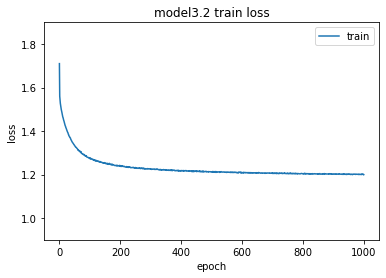

In [9]:
from matplotlib import pyplot
pyplot.plot(history.history['loss'])
pyplot.title('model3.2 train loss')
pyplot.ylabel('loss')
pyplot.xlabel('epoch')
pyplot.legend(['train'], loc='upper right')
pyplot.ylim([0.9,1.9])

In [14]:
model.save('/home/wcb/nerXY/model/model3.2.h5')